## End-to-End MLP Implementation using TensorFlow & PyTorch

**Author:** Michael C
**Dataset:** KlasifikasiUTS.csv  
**Objective:** Binary classification using advanced MLP architectures  
**Frameworks:** TensorFlow/Keras & PyTorch

---

## 1. Theoretical Foundation

### Multi-Layer Perceptron (MLP) Deep Learning Theory

#### 1.1 Forward Propagation Mathematics
For a layer `l` with input `a^(l-1)` and weights `W^(l)`, bias `b^(l)`:

**Linear Transformation:**
```
z^(l) = W^(l) × a^(l-1) + b^(l)
```

**Activation Function:**
```
a^(l) = σ(z^(l))
```

#### 1.2 Activation Functions

**ReLU (Rectified Linear Unit):**
```
f(x) = max(0, x)
f'(x) = {1 if x > 0, 0 if x ≤ 0}
```
- **Advantages:** Computationally efficient, mitigates vanishing gradient
- **Usage:** Hidden layers

**Sigmoid:**
```
σ(x) = 1 / (1 + e^(-x))
σ'(x) = σ(x) × (1 - σ(x))
```
- **Advantages:** Output bounded [0,1], smooth gradient
- **Usage:** Binary classification output layer

#### 1.3 Loss Functions

**Binary Cross-Entropy:**
```
L(y, ŷ) = -[y × log(ŷ) + (1-y) × log(1-ŷ)]
```
Where: `y` = true label, `ŷ` = predicted probability

**Gradient:**
```
∂L/∂ŷ = -y/ŷ + (1-y)/(1-ŷ)
```

#### 1.4 Backpropagation Algorithm

**Chain Rule Application:**
```
∂L/∂W^(l) = ∂L/∂z^(l) × ∂z^(l)/∂W^(l) = δ^(l) × a^(l-1)^T
∂L/∂b^(l) = δ^(l)
δ^(l) = ∂L/∂z^(l) = (W^(l+1))^T × δ^(l+1) ⊙ σ'(z^(l))
```

#### 1.5 Regularization Techniques

**L1 Regularization (Lasso):**
```
L_total = L_original + λ₁ × Σ|w_i|
```
- **Effect:** Promotes sparsity, feature selection

**L2 Regularization (Ridge):**
```
L_total = L_original + λ₂ × Σw_i²
```
- **Effect:** Prevents overfitting, weight decay

**Dropout:**
```
r_i ~ Bernoulli(p)
ỹ_i = r_i × y_i / p
```
Where: `p` = keep probability, `r_i` = dropout mask

**Batch Normalization:**
```
μ_B = (1/m) × Σx_i
σ²_B = (1/m) × Σ(x_i - μ_B)²
x̂_i = (x_i - μ_B) / √(σ²_B + ε)
y_i = γ × x̂_i + β
```
Where: `γ, β` = learnable parameters, `ε` = numerical stability

#### 1.6 Optimization Algorithms

**Adam Optimizer:**
```
m_t = β₁ × m_{t-1} + (1 - β₁) × g_t
v_t = β₂ × v_{t-1} + (1 - β₂) × g_t²
m̂_t = m_t / (1 - β₁^t)
v̂_t = v_t / (1 - β₂^t)
θ_{t+1} = θ_t - α × m̂_t / (√v̂_t + ε)
```
Where:
- `g_t`: Gradient at time t
- `m_t, v_t`: First and second moment estimates
- `β₁ = 0.9, β₂ = 0.999`: Exponential decay rates
- `α`: Learning rate
- `ε = 1e-8`: Numerical stability

**AdamW (Adam with Weight Decay):**
```
θ_{t+1} = θ_t - α × (m̂_t / (√v̂_t + ε) + λ × θ_t)
```
Where: `λ` = weight decay coefficient

In [1]:
# 1. COMPREHENSIVE LIBRARY IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import zscore
import time
import pickle
from typing import Tuple, Dict, List, Any

# Data Processing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.utils import plot_model

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import (
    StepLR, ExponentialLR, CosineAnnealingLR,
    CosineAnnealingWarmRestarts, ReduceLROnPlateau
)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Device configuration for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("🚀 COMPREHENSIVE DEEP LEARNING PIPELINE INITIALIZATION")
print("=" * 70)
print(f"📊 TensorFlow version: {tf.__version__}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"💻 Device: {device}")
print(f"🎯 GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU Name: {torch.cuda.get_device_name(0)}")

🚀 COMPREHENSIVE DEEP LEARNING PIPELINE INITIALIZATION
📊 TensorFlow version: 2.18.0
🔥 PyTorch version: 2.6.0+cu124
💻 Device: cpu
🎯 GPU Available: False


In [2]:
# 2. DATA COLLECTION & CLEANING PIPELINE

class DataProcessor:
    """
    Comprehensive Data Processing Pipeline

    Functionality:
    1. Data loading and validation
    2. Missing value handling
    3. Outlier detection and treatment
    4. Data type optimization
    5. Target variable identification
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_names = []
        self.target_column = None

    def load_and_analyze_data(self, filepath: str) -> pd.DataFrame:
        """
        Load CSV data and perform comprehensive analysis

        Target Column Detection:
        - According to requirements: column with dtype int (column[0])
        - But based on dataset structure: 'Class' column is the target
        """
        print("📁 LOADING AND ANALYZING DATASET")
        print("=" * 50)

        # Load data
        df = pd.read_csv(filepath)

        print(f"📋 Dataset loaded successfully")
        print(f"   Shape: {df.shape}")
        print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # Identify target column
        # Based on the dataset, 'Class' is the target (fraud detection: 0=normal, 1=fraud)
        if 'Class' in df.columns:
            self.target_column = 'Class'
        else:
            # Fallback: find integer columns that could be target
            int_cols = df.select_dtypes(include=['int64', 'int32']).columns
            if len(int_cols) > 0:
                # Look for binary classification target
                for col in int_cols:
                    unique_vals = df[col].unique()
                    if len(unique_vals) == 2 and set(unique_vals) == {0, 1}:
                        self.target_column = col
                        break
                if self.target_column is None:
                    self.target_column = int_cols[0]  # First integer column as fallback

        print(f"🎯 Target column identified: {self.target_column}")

        # Data quality analysis
        self._analyze_data_quality(df)

        return df

    def _analyze_data_quality(self, df: pd.DataFrame) -> None:
        """
        Comprehensive data quality analysis
        """
        print("\n🔍 DATA QUALITY ANALYSIS")
        print("-" * 30)

        # Basic statistics
        print(f"Total rows: {len(df):,}")
        print(f"Total columns: {df.shape[1]}")
        print(f"Duplicated rows: {df.duplicated().sum():,}")

        # Missing values analysis
        missing_data = df.isnull().sum()
        missing_pct = (missing_data / len(df)) * 100

        if missing_data.sum() > 0:
            print("\n❌ Missing Values Found:")
            for col in missing_data[missing_data > 0].index:
                print(f"   {col}: {missing_data[col]} ({missing_pct[col]:.2f}%)")
        else:
            print("✅ No missing values found")

        # Data types analysis
        print("\n📊 Data Types:")
        dtype_counts = df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"   {dtype}: {count} columns")

        # Target variable analysis
        if self.target_column and self.target_column in df.columns:
            target_dist = df[self.target_column].value_counts().sort_index()
            target_pct = df[self.target_column].value_counts(normalize=True).sort_index() * 100

            print(f"\n🎯 Target Variable ({self.target_column}) Distribution:")
            for value in target_dist.index:
                print(f"   Class {value}: {target_dist[value]:,} ({target_pct[value]:.2f}%)")

            # Check for class imbalance
            if len(target_dist) == 2:
                imbalance_ratio = target_dist.max() / target_dist.min()
                print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")
                if imbalance_ratio > 10:
                    print(f"   ⚠️ Highly imbalanced dataset detected!")

    def clean_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Comprehensive data cleaning pipeline

        Steps:
        1. Handle missing values
        2. Remove duplicates
        3. Outlier detection and treatment
        4. Data type optimization
        """
        print("\n🧹 DATA CLEANING PIPELINE")
        print("-" * 30)

        df_clean = df.copy()
        initial_shape = df_clean.shape

        # 1. Handle missing values
        missing_before = df_clean.isnull().sum().sum()
        if missing_before > 0:
            print(f"1️⃣ Handling {missing_before} missing values...")

            # Strategy: Forward fill for time series, median for numerical, mode for categorical
            for col in df_clean.columns:
                if df_clean[col].isnull().sum() > 0:
                    if df_clean[col].dtype in ['float64', 'int64']:
                        df_clean[col].fillna(df_clean[col].median(), inplace=True)
                    else:
                        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

            missing_after = df_clean.isnull().sum().sum()
            print(f"   ✅ Missing values reduced: {missing_before} → {missing_after}")

        # 2. Remove duplicates
        duplicates_before = df_clean.duplicated().sum()
        if duplicates_before > 0:
            print(f"2️⃣ Removing {duplicates_before} duplicate rows...")
            df_clean.drop_duplicates(inplace=True)
            duplicates_after = df_clean.duplicated().sum()
            print(f"   ✅ Duplicates removed: {duplicates_before} → {duplicates_after}")

        # 3. Outlier detection and treatment
        print("3️⃣ Outlier detection and treatment...")
        outliers_treated = self._handle_outliers(df_clean)
        print(f"   ✅ Outliers treated in {outliers_treated} columns")

        # 4. Data type optimization
        print("4️⃣ Optimizing data types...")
        df_clean = self._optimize_dtypes(df_clean)

        final_shape = df_clean.shape
        print(f"\n📊 Cleaning Summary:")
        print(f"   Shape: {initial_shape} → {final_shape}")
        print(f"   Rows removed: {initial_shape[0] - final_shape[0]:,}")
        print(f"   Memory optimization: {(df.memory_usage(deep=True).sum() - df_clean.memory_usage(deep=True).sum()) / 1024**2:.2f} MB saved")

        return df_clean

    def _handle_outliers(self, df: pd.DataFrame) -> int:
        """
        Handle outliers using IQR method for numerical columns

        Method: Cap outliers at 1.5 * IQR bounds instead of removing
        (Preserves data for fraud detection - outliers might be fraudulent)
        """
        outliers_treated = 0
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        numerical_cols = [col for col in numerical_cols if col != self.target_column]

        for col in numerical_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Count outliers
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

            if outliers > 0:
                # Cap outliers instead of removing
                df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
                outliers_treated += 1

        return outliers_treated

    def _optimize_dtypes(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Optimize data types to reduce memory usage
        """
        df_optimized = df.copy()

        for col in df_optimized.columns:
            col_type = df_optimized[col].dtype

            if col_type != 'object':
                c_min = df_optimized[col].min()
                c_max = df_optimized[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df_optimized[col] = df_optimized[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df_optimized[col] = df_optimized[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df_optimized[col] = df_optimized[col].astype(np.int32)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df_optimized[col] = df_optimized[col].astype(np.float32)

        return df_optimized

# Initialize data processor and load data
data_processor = DataProcessor()
df_raw = data_processor.load_and_analyze_data('KlasifikasiUTS.csv')
df_clean = data_processor.clean_data(df_raw)

📁 LOADING AND ANALYZING DATASET
📋 Dataset loaded successfully
   Shape: (284807, 31)
   Memory usage: 67.36 MB
🎯 Target column identified: Class

🔍 DATA QUALITY ANALYSIS
------------------------------
Total rows: 284,807
Total columns: 31
Duplicated rows: 1,081
✅ No missing values found

📊 Data Types:
   float64: 30 columns
   int64: 1 columns

🎯 Target Variable (Class) Distribution:
   Class 0: 284,315 (99.83%)
   Class 1: 492 (0.17%)
   Imbalance ratio: 577.9:1
   ⚠️ Highly imbalanced dataset detected!

🧹 DATA CLEANING PIPELINE
------------------------------
2️⃣ Removing 1081 duplicate rows...
   ✅ Duplicates removed: 1081 → 0
3️⃣ Outlier detection and treatment...
   ✅ Outliers treated in 29 columns
4️⃣ Optimizing data types...

📊 Cleaning Summary:
   Shape: (284807, 31) → (283726, 31)
   Rows removed: 1,081
   Memory optimization: 32.46 MB saved


## 2. Advanced Feature Engineering Pipeline

### Feature Engineering Mathematical Framework

#### 2.1 Normalization Techniques

**Z-Score Standardization:**
```
z = (x - μ) / σ
```
Where: `μ` = sample mean, `σ` = sample standard deviation

**Min-Max Scaling:**
```
x_scaled = (x - x_min) / (x_max - x_min)
```
Range: [0, 1]

#### 2.2 Encoding Techniques

**One-Hot Encoding:**
For categorical variable with k categories:
```
x_encoded ∈ {0,1}^k where Σx_encoded = 1
```

**Label Encoding:**
```
x_encoded ∈ {0, 1, 2, ..., k-1}
```

#### 2.3 Feature Selection Methods

**Mutual Information:**
```
I(X;Y) = ∑∑ p(x,y) log(p(x,y)/(p(x)p(y)))
```

**F-Score (ANOVA):**
```
F = (SSB/(k-1)) / (SSW/(n-k))
```
Where: SSB = Sum of Squares Between, SSW = Sum of Squares Within

In [3]:
# 3. ADVANCED FEATURE ENGINEERING PIPELINE

class AdvancedFeatureEngineer:
    """
    Comprehensive Feature Engineering for Deep Learning

    Techniques Implemented:
    1. Statistical feature creation
    2. Polynomial and interaction features
    3. Time-based feature engineering
    4. Domain-specific features for fraud detection
    5. Feature selection and dimensionality reduction
    6. Advanced encoding techniques
    """

    def __init__(self, target_column: str):
        self.target_column = target_column
        self.feature_selectors = {}
        self.encoders = {}
        self.scalers = {}
        self.engineered_features = []

    def engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply comprehensive feature engineering pipeline
        """
        print("\n🔧 ADVANCED FEATURE ENGINEERING PIPELINE")
        print("=" * 60)

        df_engineered = df.copy()
        initial_features = df.shape[1] - 1  # Exclude target

        # 1. Domain-specific features for fraud detection
        print("1️⃣ Creating domain-specific features...")
        df_engineered = self._create_fraud_specific_features(df_engineered)

        # 2. Statistical features from V columns
        print("2️⃣ Creating statistical features...")
        df_engineered = self._create_statistical_features(df_engineered)

        # 3. Time-based features
        print("3️⃣ Creating time-based features...")
        df_engineered = self._create_time_features(df_engineered)

        # 4. Amount-based features
        print("4️⃣ Creating amount-based features...")
        df_engineered = self._create_amount_features(df_engineered)

        # 5. Interaction features
        print("5️⃣ Creating interaction features...")
        df_engineered = self._create_interaction_features(df_engineered)

        # 6. Polynomial features (selective)
        print("6️⃣ Creating polynomial features...")
        df_engineered = self._create_polynomial_features(df_engineered)

        final_features = df_engineered.shape[1] - 1  # Exclude target
        new_features = final_features - initial_features

        print(f"\n✅ Feature Engineering Complete!")
        print(f"   Original features: {initial_features}")
        print(f"   Engineered features: {final_features}")
        print(f"   New features created: {new_features}")

        return df_engineered

    def _create_fraud_specific_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create domain-specific features for fraud detection

        Features based on fraud detection domain knowledge:
        1. Transaction patterns
        2. Amount anomalies
        3. Time patterns
        4. V-feature anomalies
        """
        df_new = df.copy()

        # Amount categories
        amount_percentiles = df['Amount'].quantile([0.25, 0.5, 0.75, 0.95])
        df_new['Amount_Category'] = pd.cut(
            df['Amount'],
            bins=[-np.inf, amount_percentiles[0.25], amount_percentiles[0.5],
                  amount_percentiles[0.75], amount_percentiles[0.95], np.inf],
            labels=[0, 1, 2, 3, 4]  # Use integers for deep learning
        ).astype(int)

        # Time patterns
        df_new['Time_Hours'] = (df['Time'] / 3600) % 24
        df_new['Time_Day'] = df['Time'] // (24 * 3600)

        # Business hours indicator
        df_new['Is_Business_Hours'] = ((df_new['Time_Hours'] >= 9) &
                                      (df_new['Time_Hours'] <= 17)).astype(int)

        # Weekend indicator (assuming 2-day cycle)
        df_new['Is_Weekend'] = (df_new['Time_Day'] % 7 >= 5).astype(int)

        # High-value transaction indicator
        high_value_threshold = df['Amount'].quantile(0.95)
        df_new['Is_High_Value'] = (df['Amount'] > high_value_threshold).astype(int)

        # Zero amount indicator
        df_new['Is_Zero_Amount'] = (df['Amount'] == 0).astype(int)

        self.engineered_features.extend([
            'Amount_Category', 'Time_Hours', 'Time_Day', 'Is_Business_Hours',
            'Is_Weekend', 'Is_High_Value', 'Is_Zero_Amount'
        ])

        return df_new

    def _create_statistical_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create statistical features from V columns

        Statistical measures:
        1. Central tendencies (mean, median)
        2. Dispersion measures (std, var, range)
        3. Shape measures (skewness, kurtosis)
        4. Extreme values (min, max, percentiles)
        """
        df_new = df.copy()

        # Get V features
        v_features = [col for col in df.columns if col.startswith('V')]
        v_data = df[v_features]

        # Central tendencies
        df_new['V_Mean'] = v_data.mean(axis=1)
        df_new['V_Median'] = v_data.median(axis=1)

        # Dispersion measures
        df_new['V_Std'] = v_data.std(axis=1)
        df_new['V_Var'] = v_data.var(axis=1)
        df_new['V_Range'] = v_data.max(axis=1) - v_data.min(axis=1)
        df_new['V_IQR'] = v_data.quantile(0.75, axis=1) - v_data.quantile(0.25, axis=1)

        # Shape measures
        df_new['V_Skew'] = v_data.skew(axis=1)
        df_new['V_Kurt'] = v_data.kurtosis(axis=1)

        # Extreme values
        df_new['V_Min'] = v_data.min(axis=1)
        df_new['V_Max'] = v_data.max(axis=1)
        df_new['V_Q25'] = v_data.quantile(0.25, axis=1)
        df_new['V_Q75'] = v_data.quantile(0.75, axis=1)

        # Count-based features
        df_new['V_Positive_Count'] = (v_data > 0).sum(axis=1)
        df_new['V_Negative_Count'] = (v_data < 0).sum(axis=1)
        df_new['V_Zero_Count'] = (v_data == 0).sum(axis=1)
        df_new['V_Extreme_Count'] = (np.abs(v_data) > 2).sum(axis=1)

        self.engineered_features.extend([
            'V_Mean', 'V_Median', 'V_Std', 'V_Var', 'V_Range', 'V_IQR',
            'V_Skew', 'V_Kurt', 'V_Min', 'V_Max', 'V_Q25', 'V_Q75',
            'V_Positive_Count', 'V_Negative_Count', 'V_Zero_Count', 'V_Extreme_Count'
        ])

        return df_new

    def _create_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create advanced time-based features
        """
        df_new = df.copy()

        # Cyclical encoding for time
        df_new['Time_Sin'] = np.sin(2 * np.pi * df_new['Time_Hours'] / 24)
        df_new['Time_Cos'] = np.cos(2 * np.pi * df_new['Time_Hours'] / 24)

        # Time since start
        df_new['Time_Normalized'] = (df['Time'] - df['Time'].min()) / (df['Time'].max() - df['Time'].min())

        # Time bins
        df_new['Time_Bin'] = pd.cut(df['Time'], bins=10, labels=False)

        self.engineered_features.extend([
            'Time_Sin', 'Time_Cos', 'Time_Normalized', 'Time_Bin'
        ])

        return df_new

    def _create_amount_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create amount-based features
        """
        df_new = df.copy()

        # Log transformation (handle zero amounts)
        df_new['Amount_Log'] = np.log1p(df['Amount'])

        # Square root transformation
        df_new['Amount_Sqrt'] = np.sqrt(df['Amount'])

        # Percentile rank
        df_new['Amount_Percentile'] = df['Amount'].rank(pct=True)

        # Amount deviations
        amount_mean = df['Amount'].mean()
        amount_std = df['Amount'].std()
        df_new['Amount_Z_Score'] = (df['Amount'] - amount_mean) / amount_std
        df_new['Amount_Deviation'] = np.abs(df['Amount'] - amount_mean)

        self.engineered_features.extend([
            'Amount_Log', 'Amount_Sqrt', 'Amount_Percentile',
            'Amount_Z_Score', 'Amount_Deviation'
        ])

        return df_new

    def _create_interaction_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create interaction features between important variables
        """
        df_new = df.copy()

        # Amount-Time interactions
        df_new['Amount_Time_Product'] = df['Amount'] * df['Time_Hours']
        df_new['Amount_Time_Ratio'] = df['Amount'] / (df['Time_Hours'] + 1)

        # Amount-V statistical features interactions
        df_new['Amount_V_Mean_Product'] = df['Amount'] * df_new['V_Mean']
        df_new['Amount_V_Std_Product'] = df['Amount'] * df_new['V_Std']

        # Time-V statistical features interactions
        df_new['Time_V_Mean_Product'] = df['Time_Hours'] * df_new['V_Mean']
        df_new['Time_V_Std_Product'] = df['Time_Hours'] * df_new['V_Std']

        self.engineered_features.extend([
            'Amount_Time_Product', 'Amount_Time_Ratio',
            'Amount_V_Mean_Product', 'Amount_V_Std_Product',
            'Time_V_Mean_Product', 'Time_V_Std_Product'
        ])

        return df_new

    def _create_polynomial_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create selective polynomial features for key variables
        """
        df_new = df.copy()

        # Polynomial features for Amount (most important for fraud)
        df_new['Amount_Squared'] = df['Amount'] ** 2
        df_new['Amount_Cubed'] = df['Amount'] ** 3

        # Polynomial features for Time
        df_new['Time_Squared'] = df['Time_Hours'] ** 2

        # Polynomial features for V statistical measures
        df_new['V_Mean_Squared'] = df_new['V_Mean'] ** 2
        df_new['V_Std_Squared'] = df_new['V_Std'] ** 2

        self.engineered_features.extend([
            'Amount_Squared', 'Amount_Cubed', 'Time_Squared',
            'V_Mean_Squared', 'V_Std_Squared'
        ])

        return df_new

    def select_features(self, df: pd.DataFrame, method='mutual_info', k=50) -> Tuple[pd.DataFrame, List[str]]:
        """
        Advanced feature selection using multiple methods

        Methods:
        1. Mutual Information
        2. F-score (ANOVA)
        3. Correlation-based filtering
        """
        print(f"\n🎯 FEATURE SELECTION USING {method.upper()}")
        print("-" * 40)

        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]

        if method == 'mutual_info':
            selector = SelectKBest(score_func=mutual_info_classif, k=k)
        elif method == 'f_score':
            selector = SelectKBest(score_func=f_classif, k=k)
        else:
            raise ValueError(f"Unknown method: {method}")

        X_selected = selector.fit_transform(X, y)
        selected_features = X.columns[selector.get_support()].tolist()

        # Create DataFrame with selected features
        df_selected = pd.DataFrame(X_selected, columns=selected_features, index=df.index)
        df_selected[self.target_column] = y

        print(f"   Features selected: {len(selected_features)} out of {X.shape[1]}")
        print(f"   Selection ratio: {len(selected_features)/X.shape[1]:.2%}")
        print(f"   Top 10 features: {selected_features[:10]}")

        # Store selector for later use
        self.feature_selectors[method] = selector

        return df_selected, selected_features

# Apply feature engineering
feature_engineer = AdvancedFeatureEngineer(target_column=data_processor.target_column)
df_engineered = feature_engineer.engineer_features(df_clean)

# Feature selection
df_selected, selected_features = feature_engineer.select_features(
    df_engineered, method='mutual_info', k=50
)

print(f"\n📊 Final dataset shape: {df_selected.shape}")
print(f"🎯 Target column: {data_processor.target_column}")
print(f"🔧 Selected features: {len(selected_features)}")


🔧 ADVANCED FEATURE ENGINEERING PIPELINE
1️⃣ Creating domain-specific features...
2️⃣ Creating statistical features...
3️⃣ Creating time-based features...
4️⃣ Creating amount-based features...
5️⃣ Creating interaction features...
6️⃣ Creating polynomial features...

✅ Feature Engineering Complete!
   Original features: 30
   Engineered features: 73
   New features created: 43

🎯 FEATURE SELECTION USING MUTUAL_INFO
----------------------------------------
   Features selected: 50 out of 73
   Selection ratio: 68.49%
   Top 10 features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']

📊 Final dataset shape: (283726, 51)
🎯 Target column: Class
🔧 Selected features: 50


In [4]:
# 4. DATA PREPROCESSING FOR DEEP LEARNING

class DeepLearningPreprocessor:
    """
    Advanced preprocessing pipeline specifically designed for deep learning

    Features:
    1. Intelligent train/validation/test splitting
    2. Multiple normalization strategies
    3. Class imbalance handling
    4. Data validation and quality checks
    5. Format conversion for TensorFlow and PyTorch
    """

    def __init__(self, target_column: str):
        self.target_column = target_column
        self.scaler = StandardScaler()
        self.smote = SMOTE(random_state=42)
        self.feature_names = []

    def prepare_data(self, df: pd.DataFrame, test_size: float = 0.2,
                    val_size: float = 0.2, balance_classes: bool = True,
                    normalization: str = 'standard') -> Dict[str, Any]:
        """
        Comprehensive data preparation for deep learning

        Args:
            df: Input DataFrame
            test_size: Proportion for test set
            val_size: Proportion for validation set (from remaining data)
            balance_classes: Whether to apply SMOTE for class balancing
            normalization: 'standard', 'minmax', or 'robust'

        Returns:
            Dictionary containing all processed datasets and metadata
        """
        print("\n🔄 DEEP LEARNING DATA PREPROCESSING")
        print("=" * 50)

        # 1. Separate features and target
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        self.feature_names = X.columns.tolist()

        print(f"📊 Dataset overview:")
        print(f"   Total samples: {len(df):,}")
        print(f"   Features: {X.shape[1]}")
        print(f"   Target distribution: {dict(y.value_counts().sort_index())}")

        # 2. Train-test split (stratified)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # 3. Train-validation split
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
        )

        print(f"\n📋 Data splits:")
        print(f"   Training: {X_train.shape[0]:,} ({X_train.shape[0]/len(df)*100:.1f}%)")
        print(f"   Validation: {X_val.shape[0]:,} ({X_val.shape[0]/len(df)*100:.1f}%)")
        print(f"   Test: {X_test.shape[0]:,} ({X_test.shape[0]/len(df)*100:.1f}%)")

        # 4. Feature normalization
        print(f"\n🔧 Applying {normalization} normalization...")
        X_train_scaled, X_val_scaled, X_test_scaled = self._normalize_features(
            X_train, X_val, X_test, method=normalization
        )

        # 5. Handle class imbalance
        if balance_classes:
            print("\n⚖️ Balancing classes with SMOTE...")
            X_train_balanced, y_train_balanced = self.smote.fit_resample(
                X_train_scaled, y_train
            )

            print(f"   Original training: {dict(y_train.value_counts().sort_index())}")
            print(f"   Balanced training: {dict(pd.Series(y_train_balanced).value_counts().sort_index())}")
        else:
            X_train_balanced, y_train_balanced = X_train_scaled, y_train

        # 6. Convert to appropriate formats
        data_dict = {
            # Original splits (for unbalanced comparison)
            'X_train_original': X_train_scaled,
            'y_train_original': y_train.values,

            # Balanced training data
            'X_train': X_train_balanced,
            'y_train': y_train_balanced,

            # Validation and test (never balanced)
            'X_val': X_val_scaled,
            'y_val': y_val.values,
            'X_test': X_test_scaled,
            'y_test': y_test.values,

            # Metadata
            'feature_names': self.feature_names,
            'n_features': len(self.feature_names),
            'n_classes': len(y.unique()),
            'class_names': sorted(y.unique()),
            'scaler': self.scaler,
            'smote': self.smote if balance_classes else None
        }

        # 7. Data validation
        self._validate_data(data_dict)

        print("\n✅ Data preprocessing completed successfully!")

        return data_dict

    def _normalize_features(self, X_train: pd.DataFrame, X_val: pd.DataFrame,
                           X_test: pd.DataFrame, method: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Apply feature normalization using specified method
        """
        if method == 'standard':
            self.scaler = StandardScaler()
        elif method == 'minmax':
            from sklearn.preprocessing import MinMaxScaler
            self.scaler = MinMaxScaler()
        elif method == 'robust':
            from sklearn.preprocessing import RobustScaler
            self.scaler = RobustScaler()
        else:
            raise ValueError(f"Unknown normalization method: {method}")

        # Fit on training data only
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        return X_train_scaled, X_val_scaled, X_test_scaled

    def _validate_data(self, data_dict: Dict[str, Any]) -> None:
        """
        Comprehensive data validation
        """
        print("\n🔍 Data validation checks:")

        # Check for NaN/Inf values
        for split in ['X_train', 'X_val', 'X_test']:
            X = data_dict[split]
            nan_count = np.isnan(X).sum()
            inf_count = np.isinf(X).sum()

            if nan_count > 0 or inf_count > 0:
                print(f"   ❌ {split}: {nan_count} NaN, {inf_count} Inf values")
            else:
                print(f"   ✅ {split}: No NaN/Inf values")

        # Check feature statistics
        X_train = data_dict['X_train']
        print(f"   📊 Training data statistics:")
        print(f"      Mean: {X_train.mean():.4f} ± {X_train.std():.4f}")
        print(f"      Range: [{X_train.min():.4f}, {X_train.max():.4f}]")

        # Check target distribution
        for split in ['y_train', 'y_val', 'y_test']:
            y = data_dict[split]
            dist = pd.Series(y).value_counts().sort_index()
            print(f"   🎯 {split} distribution: {dict(dist)}")

    def create_tensorflow_datasets(self, data_dict: Dict[str, Any],
                                  batch_size: int = 32) -> Dict[str, tf.data.Dataset]:
        """
        Create TensorFlow datasets with optimizations
        """
        tf_datasets = {}

        # Training dataset with shuffling
        train_dataset = tf.data.Dataset.from_tensor_slices((
            data_dict['X_train'].astype(np.float32),
            data_dict['y_train'].astype(np.float32)
        ))
        train_dataset = train_dataset.shuffle(buffer_size=10000)
        train_dataset = train_dataset.batch(batch_size)
        train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
        tf_datasets['train'] = train_dataset

        # Validation dataset
        val_dataset = tf.data.Dataset.from_tensor_slices((
            data_dict['X_val'].astype(np.float32),
            data_dict['y_val'].astype(np.float32)
        ))
        val_dataset = val_dataset.batch(batch_size)
        val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
        tf_datasets['val'] = val_dataset

        # Test dataset
        test_dataset = tf.data.Dataset.from_tensor_slices((
            data_dict['X_test'].astype(np.float32),
            data_dict['y_test'].astype(np.float32)
        ))
        test_dataset = test_dataset.batch(batch_size)
        tf_datasets['test'] = test_dataset

        return tf_datasets

    def create_pytorch_dataloaders(self, data_dict: Dict[str, Any],
                                  batch_size: int = 32, num_workers: int = 2) -> Dict[str, DataLoader]:
        """
        Create PyTorch DataLoaders with optimizations
        """
        dataloaders = {}

        # Training DataLoader with shuffling
        train_dataset = TensorDataset(
            torch.FloatTensor(data_dict['X_train']),
            torch.FloatTensor(data_dict['y_train'])
        )
        dataloaders['train'] = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            num_workers=num_workers, pin_memory=True
        )

        # Validation DataLoader
        val_dataset = TensorDataset(
            torch.FloatTensor(data_dict['X_val']),
            torch.FloatTensor(data_dict['y_val'])
        )
        dataloaders['val'] = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=True
        )

        # Test DataLoader
        test_dataset = TensorDataset(
            torch.FloatTensor(data_dict['X_test']),
            torch.FloatTensor(data_dict['y_test'])
        )
        dataloaders['test'] = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=True
        )

        return dataloaders

# Prepare data for deep learning
dl_preprocessor = DeepLearningPreprocessor(target_column=data_processor.target_column)
data_dict = dl_preprocessor.prepare_data(
    df_selected,
    test_size=0.2,
    val_size=0.2,
    balance_classes=True,
    normalization='standard'
)

# Create datasets for both frameworks
tf_datasets = dl_preprocessor.create_tensorflow_datasets(data_dict, batch_size=64)
torch_dataloaders = dl_preprocessor.create_pytorch_dataloaders(data_dict, batch_size=64)

print(f"\n🎯 Data preparation summary:")
print(f"   Features: {data_dict['n_features']}")
print(f"   Classes: {data_dict['n_classes']} {data_dict['class_names']}")
print(f"   Training samples: {len(data_dict['X_train']):,}")
print(f"   Validation samples: {len(data_dict['X_val']):,}")
print(f"   Test samples: {len(data_dict['X_test']):,}")


🔄 DEEP LEARNING DATA PREPROCESSING
📊 Dataset overview:
   Total samples: 283,726
   Features: 50
   Target distribution: {0: np.int64(283253), 1: np.int64(473)}

📋 Data splits:
   Training: 181,584 (64.0%)
   Validation: 45,396 (16.0%)
   Test: 56,746 (20.0%)

🔧 Applying standard normalization...

⚖️ Balancing classes with SMOTE...
   Original training: {0: np.int64(181282), 1: np.int64(302)}
   Balanced training: {0: np.int64(181282), 1: np.int64(181282)}

🔍 Data validation checks:
   ✅ X_train: No NaN/Inf values
   ✅ X_val: No NaN/Inf values
   ✅ X_test: No NaN/Inf values
   📊 Training data statistics:
      Mean: 0.0734 ± 1.9707
      Range: [-12.6030, 24.1371]
   🎯 y_train distribution: {0: np.int64(181282), 1: np.int64(181282)}
   🎯 y_val distribution: {0: np.int64(45320), 1: np.int64(76)}
   🎯 y_test distribution: {0: np.int64(56651), 1: np.int64(95)}

✅ Data preprocessing completed successfully!

🎯 Data preparation summary:
   Features: 50
   Classes: 2 [np.int8(0), np.int8(1)]

## 3. TensorFlow/Keras MLP Implementation

### Advanced Deep Learning Architecture

#### 3.1 Network Architecture Design Principles

**Layer Size Progression:**
```
Input → Large → Medium → Small → Output
n_features → 256 → 128 → 64 → 1
```

**Regularization Stack:**
1. **Batch Normalization:** Normalizes inputs to each layer
2. **Dropout:** Randomly sets neurons to zero during training
3. **L1/L2 Regularization:** Penalty on weights

#### 3.2 Advanced Optimization Techniques

**Learning Rate Scheduling:**
- **Exponential Decay:** `lr = lr₀ × decay_rate^(step/decay_steps)`
- **Cosine Annealing:** `lr = lr_min + (lr_max - lr_min) × (1 + cos(π × T_cur/T_max))/2`
- **Warm Restarts:** Periodic learning rate resets

**Early Stopping Criteria:**
```
if val_loss[t] > min(val_loss[t-patience:t]) + min_delta:
    stop_training = True
```

In [5]:
# 5. TENSORFLOW/KERAS MLP IMPLEMENTATION

class TensorFlowMLPClassifier:
    """
    Advanced MLP Classifier using TensorFlow/Keras

    Features:
    1. Modular architecture design
    2. Advanced regularization techniques
    3. Learning rate scheduling
    4. Early stopping and model checkpointing
    5. Comprehensive callbacks
    6. Custom metrics and loss functions
    """

    def __init__(self, input_dim: int, architecture_config: Dict[str, Any]):
        self.input_dim = input_dim
        self.config = architecture_config
        self.model = None
        self.history = None
        self.callbacks = []

    def build_model(self) -> tf.keras.Model:
        """
        Build advanced MLP architecture with regularization

        Architecture Components:
        1. Input layer with proper initialization
        2. Hidden layers with batch normalization
        3. Dropout layers for regularization
        4. L1/L2 weight regularization
        5. Output layer with appropriate activation
        """
        print("\n🏗️ Building TensorFlow MLP Architecture")
        print("-" * 40)

        # Model architecture
        model = tf.keras.Sequential(name='Advanced_MLP_Classifier')

        # Input layer
        model.add(layers.InputLayer(input_shape=(self.input_dim,), name='input_layer'))

        # Hidden layers with advanced regularization
        hidden_layers = self.config.get('hidden_layers', [256, 128, 64])
        dropout_rate = self.config.get('dropout_rate', 0.3)
        l1_reg = self.config.get('l1_regularization', 0.01)
        l2_reg = self.config.get('l2_regularization', 0.01)
        use_batch_norm = self.config.get('use_batch_norm', True)
        activation = self.config.get('activation', 'relu')

        for i, units in enumerate(hidden_layers):
            # Dense layer with regularization
            model.add(layers.Dense(
                units,
                activation=None,  # Apply activation after batch norm
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.L1L2(l1=l1_reg, l2=l2_reg),
                name=f'dense_{i+1}'
            ))

            # Batch normalization
            if use_batch_norm:
                model.add(layers.BatchNormalization(name=f'batch_norm_{i+1}'))

            # Activation
            model.add(layers.Activation(activation, name=f'activation_{i+1}'))

            # Dropout
            model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))

        # Output layer for binary classification
        model.add(layers.Dense(
            1,
            activation='sigmoid',
            kernel_initializer='glorot_normal',
            name='output_layer'
        ))

        # Print model architecture
        print(f"   Architecture: {[self.input_dim] + hidden_layers + [1]}")
        print(f"   Total parameters: {model.count_params():,}")
        print(f"   Dropout rate: {dropout_rate}")
        print(f"   L1 regularization: {l1_reg}")
        print(f"   L2 regularization: {l2_reg}")
        print(f"   Batch normalization: {use_batch_norm}")

        self.model = model
        return model

    def compile_model(self, optimizer_config: Dict[str, Any],
                     loss_config: Dict[str, Any]) -> None:
        """
        Compile model with advanced optimizer and loss configurations

        Optimizers Supported:
        1. Adam with custom parameters
        2. AdamW (Adam with weight decay)
        3. RMSprop
        4. SGD with momentum
        """
        print("\n⚙️ Compiling TensorFlow Model")
        print("-" * 30)

        # Configure optimizer
        optimizer_name = optimizer_config.get('name', 'adam')
        learning_rate = optimizer_config.get('learning_rate', 0.001)

        if optimizer_name.lower() == 'adam':
            optimizer = optimizers.Adam(
                learning_rate=learning_rate,
                beta_1=optimizer_config.get('beta_1', 0.9),
                beta_2=optimizer_config.get('beta_2', 0.999),
                epsilon=optimizer_config.get('epsilon', 1e-7)
            )
        elif optimizer_name.lower() == 'adamw':
            # Correct initialization for AdamW in recent Keras versions
            try:
                 optimizer = optimizers.AdamW(
                    learning_rate=learning_rate,
                    weight_decay=optimizer_config.get('weight_decay', 0.01),
                    beta_1=optimizer_config.get('beta_1', 0.9),
                    beta_2=optimizer_config.get('beta_2', 0.999)
                )
            except AttributeError:
                 # Fallback for older versions if needed, though AdamW is standard now
                 print("Warning: AdamW directly not found, using Adam with weight decay in kernel regularization.")
                 optimizer = optimizers.Adam(
                    learning_rate=learning_rate,
                    beta_1=optimizer_config.get('beta_1', 0.9),
                    beta_2=optimizer_config.get('beta_2', 0.999),
                    epsilon=optimizer_config.get('epsilon', 1e-7)
                 )

        elif optimizer_name.lower() == 'rmsprop':
            optimizer = optimizers.RMSprop(
                learning_rate=learning_rate,
                rho=optimizer_config.get('rho', 0.9),
                epsilon=optimizer_config.get('epsilon', 1e-7)
            )
        elif optimizer_name.lower() == 'sgd':
            optimizer = optimizers.SGD(
                learning_rate=learning_rate,
                momentum=optimizer_config.get('momentum', 0.9),
                nesterov=optimizer_config.get('nesterov', True)
            )
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")

        # Configure loss function
        loss_name = loss_config.get('name', 'binary_crossentropy')

        if loss_name == 'binary_crossentropy':
            loss = 'binary_crossentropy'
        elif loss_name == 'focal_loss':
            # Custom focal loss for imbalanced data
            alpha = loss_config.get('alpha', 0.25)
            gamma = loss_config.get('gamma', 2.0)
            loss = self._focal_loss(alpha=alpha, gamma=gamma)
        else:
            loss = loss_name

        # Comprehensive metrics
        metrics = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.AUC(name='pr_auc', curve='PR')
        ]

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )

        print(f"   Optimizer: {optimizer_name} (lr={learning_rate})")
        print(f"   Loss function: {loss_name}")
        print(f"   Metrics: {[m.name if hasattr(m, 'name') else str(m) for m in metrics]}")

    def _focal_loss(self, alpha: float = 0.25, gamma: float = 2.0):
        """
        Focal Loss for addressing class imbalance

        Formula: FL(p_t) = -α_t × (1 - p_t)^γ × log(p_t)
        """
        def focal_loss_fn(y_true, y_pred):
            # Clip predictions to prevent log(0)
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

            # Calculate focal loss
            alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
            p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
            focal_loss = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)

            return tf.reduce_mean(focal_loss)

        return focal_loss_fn

    def setup_callbacks(self, callback_config: Dict[str, Any]) -> List[tf.keras.callbacks.Callback]:
        """
        Setup comprehensive callbacks for training

        Callbacks:
        1. Early Stopping
        2. Model Checkpointing
        3. Learning Rate Scheduling
        4. ReduceLROnPlateau
        5. TensorBoard Logging
        """
        self.callbacks = []

        # Early Stopping
        if callback_config.get('early_stopping', True):
            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',
                patience=callback_config.get('early_stopping_patience', 10),
                restore_best_weights=True,
                verbose=1
            )
            self.callbacks.append(early_stopping)

        # Model Checkpointing
        if callback_config.get('model_checkpoint', True):
            checkpoint = callbacks.ModelCheckpoint(
                'best_tf_model.h5',
                monitor='val_auc',
                mode='max',
                save_best_only=True,
                verbose=1
            )
            self.callbacks.append(checkpoint)

        # Learning Rate Reduction
        if callback_config.get('reduce_lr', True):
            reduce_lr = callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=callback_config.get('lr_reduction_factor', 0.5),
                patience=callback_config.get('lr_reduction_patience', 5),
                min_lr=callback_config.get('min_lr', 1e-7),
                verbose=1
            )
            self.callbacks.append(reduce_lr)

        # Learning Rate Scheduling
        if callback_config.get('lr_scheduler', False):
            scheduler_type = callback_config.get('scheduler_type', 'exponential')

            if scheduler_type == 'exponential':
                lr_scheduler = callbacks.LearningRateScheduler(
                    lambda epoch: callback_config.get('initial_lr', 0.001) *
                    (callback_config.get('decay_rate', 0.95) ** epoch)
                )
            elif scheduler_type == 'cosine':
                lr_scheduler = callbacks.LearningRateScheduler(
                    lambda epoch: callback_config.get('min_lr', 1e-6) +
                    (callback_config.get('max_lr', 0.001) - callback_config.get('min_lr', 1e-6)) *
                    (1 + np.cos(np.pi * epoch / callback_config.get('total_epochs', 100))) / 2
                )

            self.callbacks.append(lr_scheduler)

        print(f"\n📋 Callbacks configured: {len(self.callbacks)}")
        for cb in self.callbacks:
            print(f"   - {cb.__class__.__name__}")

        return self.callbacks

    def train(self, train_dataset: tf.data.Dataset, val_dataset: tf.data.Dataset,
             epochs: int = 100, verbose: int = 1) -> tf.keras.callbacks.History:
        """
        Train the model with comprehensive monitoring
        """
        print(f"\n🚀 Starting TensorFlow Model Training")
        print(f"   Epochs: {epochs}")
        print(f"   Callbacks: {len(self.callbacks)}")
        print("-" * 40)

        start_time = time.time()

        self.history = self.model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=self.callbacks,
            verbose=verbose
        )

        training_time = time.time() - start_time

        print(f"\n✅ Training completed in {training_time:.2f} seconds")
        print(f"   Best validation AUC: {max(self.history.history['val_auc']):.4f}")
        print(f"   Final validation loss: {self.history.history['val_loss'][-1]:.4f}")

        return self.history

    def evaluate(self, test_dataset: tf.data.Dataset) -> Dict[str, float]:
        """
        Comprehensive model evaluation
        """
        print("\n📊 Evaluating TensorFlow Model")
        print("-" * 30)

        # Model evaluation
        results = self.model.evaluate(test_dataset, verbose=0)
        metric_names = self.model.metrics_names

        evaluation_dict = dict(zip(metric_names, results))

        print("   Test Results:")
        for metric, value in evaluation_dict.items():
            print(f"     {metric}: {value:.4f}")

        return evaluation_dict

    def predict(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Make predictions with the trained model
        """
        probabilities = self.model.predict(X, verbose=0)
        predictions = (probabilities > 0.5).astype(int)

        return predictions.flatten(), probabilities.flatten()

# Configure and build TensorFlow model
tf_architecture_config = {
    'hidden_layers': [256, 128, 64, 32],
    'dropout_rate': 0.3,
    'l1_regularization': 0.01,
    'l2_regularization': 0.01,
    'use_batch_norm': True,
    'activation': 'relu'
}

tf_optimizer_config = {
    'name': 'adamw',
    'learning_rate': 0.001,
    'weight_decay': 0.01,
    'beta_1': 0.9,
    'beta_2': 0.999
}

tf_loss_config = {
    'name': 'focal_loss',
    'alpha': 0.25,
    'gamma': 2.0
}

tf_callback_config = {
    'early_stopping': True,
    'early_stopping_patience': 15,
    'model_checkpoint': True,
    'reduce_lr': True,
    'lr_reduction_factor': 0.5,
    'lr_reduction_patience': 7,
    'min_lr': 1e-7
}

# Initialize and build TensorFlow model
tf_classifier = TensorFlowMLPClassifier(
    input_dim=data_dict['n_features'],
    architecture_config=tf_architecture_config
)

tf_model = tf_classifier.build_model()
tf_classifier.compile_model(tf_optimizer_config, tf_loss_config)
tf_callbacks = tf_classifier.setup_callbacks(tf_callback_config)

# Display model summary
print("\n📋 TensorFlow Model Summary:")
tf_model.summary()


🏗️ Building TensorFlow MLP Architecture
----------------------------------------
   Architecture: [50, 256, 128, 64, 32, 1]
   Total parameters: 58,241
   Dropout rate: 0.3
   L1 regularization: 0.01
   L2 regularization: 0.01
   Batch normalization: True

⚙️ Compiling TensorFlow Model
------------------------------
   Optimizer: adamw (lr=0.001)
   Loss function: focal_loss
   Metrics: ['accuracy', 'precision', 'recall', 'auc', 'pr_auc']

📋 Callbacks configured: 3
   - EarlyStopping
   - ModelCheckpoint
   - ReduceLROnPlateau

📋 TensorFlow Model Summary:


Model: "Advanced_MLP_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,241 (227.50 KB)

 Trainable params: 57,281 (223.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [6]:
# Train TensorFlow model
print("\n🔥 TRAINING TENSORFLOW MODEL")
print("=" * 50)

tf_history = tf_classifier.train(
    train_dataset=tf_datasets['train'],
    val_dataset=tf_datasets['val'],
    epochs=20,
    verbose=1
)

# Evaluate TensorFlow model
tf_results = tf_classifier.evaluate(tf_datasets['test'])

# Make predictions
tf_predictions, tf_probabilities = tf_classifier.predict(data_dict['X_test'])


🔥 TRAINING TENSORFLOW MODEL

🚀 Starting TensorFlow Model Training
   Epochs: 20
   Callbacks: 3
----------------------------------------
Epoch 1/20
5660/5666 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9601 - auc: 0.7217 - loss: 5.1764 - pr_auc: 0.4595 - precision: 0.4485 - recall: 0.4441
Epoch 1: val_auc improved from -inf to 0.50000, saving model to best_tf_model.h5


5666/5666 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - accuracy: 0.9601 - auc: 0.7221 - loss: 5.1714 - pr_auc: 0.4602 - precision: 0.4492 - recall: 0.4447 - val_accuracy: 0.0017 - val_auc: 0.5000 - val_loss: 2.3286 - val_pr_auc: 0.0017 - val_precision: 0.0017 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
5662/5666 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9477 - auc: 0.7489 - loss: 0.1740 - pr_auc: 0.4441 - precision: 0.4676 - recall: 0.5125
Epoch 2: val_auc did not improve from 0.50000
5666/5666 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9477 - auc: 0.7491 - loss: 0.1739 - pr_auc: 0.4446 - precision: 0.4681 - recall: 0.5129 - val_accuracy: 0.0017 - val_auc: 0.5000 - val_loss: 2.0888 - val_pr_auc: 0.0017 - val_precision: 0.0017 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
5665/5666 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9559 - auc: 0.7451 - loss: 0.1330 - pr_auc: 0.4538 - precision: 0.4727 - recall: 0.5166
Epoch 3: val_auc did not improve from 0.50000
5666

## 4. PyTorch MLP Implementation

### Advanced PyTorch Architecture

#### 4.1 Custom Neural Network Class

**PyTorch Model Structure:**
```python
class AdvancedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate):
        super().__init__()
        # Modular layer construction
        # Batch normalization integration
        # Flexible activation functions
```

#### 4.2 Advanced Training Loop

**Training Algorithm:**
```
for epoch in range(num_epochs):
    for batch in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (optional)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        scheduler.step()  # Learning rate scheduling
```

#### 4.3 Advanced Learning Rate Schedulers

**Cosine Annealing with Warm Restarts:**
```
lr = η_min + (η_max - η_min) × (1 + cos(π × T_cur/T_max))/2
```
Where: `T_cur` = current epoch, `T_max` = restart period

In [7]:
# 6. PYTORCH MLP IMPLEMENTATION

class AdvancedMLPPyTorch(nn.Module):
    """
    Advanced MLP Classifier using PyTorch

    Features:
    1. Modular architecture design
    2. Batch normalization and dropout
    3. Flexible activation functions
    4. Weight initialization strategies
    5. Residual connections (optional)
    """

    def __init__(self, input_dim: int, hidden_dims: List[int],
                 dropout_rate: float = 0.3, use_batch_norm: bool = True,
                 activation: str = 'relu', use_residual: bool = False):
        super(AdvancedMLPPyTorch, self).__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_residual = use_residual

        # Activation function selection
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation == 'elu':
            self.activation = nn.ELU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            self.activation = nn.ReLU()

        # Build layers
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input to first hidden layer
        prev_dim = input_dim

        for i, hidden_dim in enumerate(hidden_dims):
            # Linear layer
            linear = nn.Linear(prev_dim, hidden_dim)

            # Initialize weights
            nn.init.kaiming_normal_(linear.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(linear.bias, 0)

            self.layers.append(linear)

            # Batch normalization
            if use_batch_norm:
                self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
            else:
                self.batch_norms.append(nn.Identity())

            # Dropout
            self.dropouts.append(nn.Dropout(dropout_rate))

            prev_dim = hidden_dim

        # Output layer
        self.output_layer = nn.Linear(prev_dim, 1)
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0)

        # Output activation
        self.sigmoid = nn.Sigmoid()

        print(f"\n🏗️ PyTorch MLP Architecture Built:")
        print(f"   Input dim: {input_dim}")
        print(f"   Hidden dims: {hidden_dims}")
        print(f"   Total parameters: {self.count_parameters():,}")
        print(f"   Dropout rate: {dropout_rate}")
        print(f"   Batch normalization: {use_batch_norm}")
        print(f"   Activation: {activation}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """
        # Store input for potential residual connections
        residual = None

        for i, (layer, batch_norm, dropout) in enumerate(zip(self.layers, self.batch_norms, self.dropouts)):
            # Store for residual connection (if dimensions match)
            if self.use_residual and i > 0 and x.shape[1] == layer.out_features:
                residual = x

            # Linear transformation
            x = layer(x)

            # Batch normalization
            x = batch_norm(x)

            # Activation
            x = self.activation(x)

            # Residual connection
            if self.use_residual and residual is not None and x.shape == residual.shape:
                x = x + residual

            # Dropout
            x = dropout(x)

        # Output layer
        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x

    def count_parameters(self) -> int:
        """
        Count total trainable parameters
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class PyTorchMLPTrainer:
    """
    Advanced PyTorch MLP Trainer with comprehensive features

    Features:
    1. Multiple loss functions
    2. Advanced optimizers and schedulers
    3. Early stopping
    4. Model checkpointing
    5. Comprehensive logging
    6. Gradient clipping
    """

    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device
        self.optimizer = None
        self.scheduler = None
        self.criterion = None
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_auc': [], 'val_auc': [],
            'learning_rate': []
        }
        self.best_val_auc = 0.0
        self.patience_counter = 0

    def setup_training(self, optimizer_config: Dict[str, Any],
                      scheduler_config: Dict[str, Any],
                      loss_config: Dict[str, Any]) -> None:
        """
        Setup optimizer, scheduler, and loss function
        """
        print("\n⚙️ Setting up PyTorch Training Components")
        print("-" * 40)

        # Setup optimizer
        optimizer_name = optimizer_config.get('name', 'adamw')
        lr = optimizer_config.get('learning_rate', 0.001)
        weight_decay = optimizer_config.get('weight_decay', 0.01)

        if optimizer_name.lower() == 'adamw':
            self.optimizer = optim.AdamW(
                self.model.parameters(),
                lr=lr,
                weight_decay=weight_decay,
                betas=(optimizer_config.get('beta1', 0.9), optimizer_config.get('beta2', 0.999))
            )
        elif optimizer_name.lower() == 'adam':
            self.optimizer = optim.Adam(
                self.model.parameters(),
                lr=lr,
                weight_decay=weight_decay,
                betas=(optimizer_config.get('beta1', 0.9), optimizer_config.get('beta2', 0.999))
            )
        elif optimizer_name.lower() == 'sgd':
            self.optimizer = optim.SGD(
                self.model.parameters(),
                lr=lr,
                momentum=optimizer_config.get('momentum', 0.9),
                weight_decay=weight_decay,
                nesterov=optimizer_config.get('nesterov', True)
            )

        # Setup scheduler
        scheduler_name = scheduler_config.get('name', 'cosine_warm_restarts')

        if scheduler_name == 'cosine_warm_restarts':
            self.scheduler = CosineAnnealingWarmRestarts(
                self.optimizer,
                T_0=scheduler_config.get('T_0', 10),
                T_mult=scheduler_config.get('T_mult', 2),
                eta_min=scheduler_config.get('eta_min', 1e-6)
            )
        elif scheduler_name == 'reduce_on_plateau':
            self.scheduler = ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                factor=scheduler_config.get('factor', 0.5),
                patience=scheduler_config.get('patience', 5),
                min_lr=scheduler_config.get('min_lr', 1e-7)
            )
        elif scheduler_name == 'cosine_annealing':
            self.scheduler = CosineAnnealingLR(
                self.optimizer,
                T_max=scheduler_config.get('T_max', 50),
                eta_min=scheduler_config.get('eta_min', 1e-6)
            )

        # Setup loss function
        loss_name = loss_config.get('name', 'bce')

        if loss_name == 'bce':
            self.criterion = nn.BCELoss()
        elif loss_name == 'focal':
            self.criterion = self._focal_loss(
                alpha=loss_config.get('alpha', 0.25),
                gamma=loss_config.get('gamma', 2.0)
            )
        elif loss_name == 'weighted_bce':
            pos_weight = torch.tensor([loss_config.get('pos_weight', 1.0)]).to(self.device)
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        print(f"   Optimizer: {optimizer_name} (lr={lr}, wd={weight_decay})")
        print(f"   Scheduler: {scheduler_name}")
        print(f"   Loss function: {loss_name}")

    def _focal_loss(self, alpha: float = 0.25, gamma: float = 2.0):
        """
        Focal Loss implementation for PyTorch
        """
        def focal_loss_fn(predictions, targets):
            # Ensure predictions are probabilities
            predictions = torch.clamp(predictions, 1e-8, 1 - 1e-8)

            # Calculate focal loss
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
            p_t = predictions * targets + (1 - predictions) * (1 - targets)
            focal_loss = -alpha_t * torch.pow((1 - p_t), gamma) * torch.log(p_t)

            return focal_loss.mean()

        return focal_loss_fn

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, float, float]:
        """
        Train for one epoch
        """
        self.model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        all_predictions = []
        all_targets = []

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            target = target.unsqueeze(1)  # Add dimension for BCE loss

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            output = self.model(data)
            loss = self.criterion(output, target)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Optimizer step
            self.optimizer.step()

            # Update scheduler (if not ReduceLROnPlateau)
            if not isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step()

            # Calculate metrics
            total_loss += loss.item()
            predicted = (output > 0.5).float()
            correct_predictions += (predicted == target).sum().item()
            total_samples += target.size(0)

            # Store for AUC calculation
            all_predictions.extend(output.detach().cpu().numpy())
            all_targets.extend(target.detach().cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples

        # Calculate AUC
        try:
            auc = roc_auc_score(all_targets, all_predictions)
        except:
            auc = 0.0

        return avg_loss, accuracy, auc

    def validate_epoch(self, val_loader: DataLoader) -> Tuple[float, float, float]:
        """
        Validate for one epoch
        """
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                target = target.unsqueeze(1)

                # Forward pass
                output = self.model(data)
                loss = self.criterion(output, target)

                # Calculate metrics
                total_loss += loss.item()
                predicted = (output > 0.5).float()
                correct_predictions += (predicted == target).sum().item()
                total_samples += target.size(0)

                # Store for AUC calculation
                all_predictions.extend(output.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        avg_loss = total_loss / len(val_loader)
        accuracy = correct_predictions / total_samples

        # Calculate AUC
        try:
            auc = roc_auc_score(all_targets, all_predictions)
        except:
            auc = 0.0

        return avg_loss, accuracy, auc

    def train(self, train_loader: DataLoader, val_loader: DataLoader,
             num_epochs: int = 20, patience: int = 15,
             save_best: bool = True) -> Dict[str, List[float]]:
        """
        Complete training loop with early stopping
        """
        print(f"\n🚀 Starting PyTorch Model Training")
        print(f"   Epochs: {num_epochs}")
        print(f"   Early stopping patience: {patience}")
        print("-" * 40)

        start_time = time.time()

        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc, train_auc = self.train_epoch(train_loader)

            # Validation
            val_loss, val_acc, val_auc = self.validate_epoch(val_loader)

            # Update scheduler (for ReduceLROnPlateau)
            if isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step(val_loss)

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['train_auc'].append(train_auc)
            self.history['val_auc'].append(val_auc)
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])

            # Print progress
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                      f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                      f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f} | "
                      f"LR: {self.optimizer.param_groups[0]['lr']:.2e}")

            # Early stopping and model saving
            if val_auc > self.best_val_auc:
                self.best_val_auc = val_auc
                self.patience_counter = 0

                if save_best:
                    torch.save(self.model.state_dict(), 'best_pytorch_model.pth')
            else:
                self.patience_counter += 1

                if self.patience_counter >= patience:
                    print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
                    print(f"   Best validation AUC: {self.best_val_auc:.4f}")
                    break

        training_time = time.time() - start_time

        print(f"\n✅ PyTorch training completed in {training_time:.2f} seconds")
        print(f"   Best validation AUC: {self.best_val_auc:.4f}")
        print(f"   Final validation loss: {self.history['val_loss'][-1]:.4f}")

        # Load best model
        if save_best:
            self.model.load_state_dict(torch.load('best_pytorch_model.pth'))

        return self.history

    def evaluate(self, test_loader: DataLoader) -> Dict[str, float]:
        """
        Comprehensive model evaluation
        """
        print("\n📊 Evaluating PyTorch Model")
        print("-" * 30)

        self.model.eval()
        all_predictions = []
        all_probabilities = []
        all_targets = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)
                predicted = (output > 0.5).float()

                all_predictions.extend(predicted.cpu().numpy())
                all_probabilities.extend(output.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        # Convert to numpy arrays
        predictions = np.array(all_predictions).flatten()
        probabilities = np.array(all_probabilities).flatten()
        targets = np.array(all_targets).flatten()

        # Calculate comprehensive metrics
        accuracy = accuracy_score(targets, predictions)
        precision = precision_score(targets, predictions)
        recall = recall_score(targets, predictions)
        f1 = f1_score(targets, predictions)
        auc = roc_auc_score(targets, probabilities)
        pr_auc = average_precision_score(targets, probabilities)

        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'pr_auc': pr_auc
        }

        print("   Test Results:")
        for metric, value in results.items():
            print(f"     {metric}: {value:.4f}")

        return results

    def predict(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Make predictions with the trained model
        """
        self.model.eval()
        X_tensor = torch.FloatTensor(X).to(self.device)

        with torch.no_grad():
            probabilities = self.model(X_tensor).cpu().numpy()
            predictions = (probabilities > 0.5).astype(int)

        return predictions.flatten(), probabilities.flatten()

# Configure and build PyTorch model
pytorch_model = AdvancedMLPPyTorch(
    input_dim=data_dict['n_features'],
    hidden_dims=[256, 128, 64, 32],
    dropout_rate=0.3,
    use_batch_norm=True,
    activation='relu',
    use_residual=False
)

pytorch_trainer = PyTorchMLPTrainer(pytorch_model, device)

# Setup training components
pytorch_optimizer_config = {
    'name': 'adamw',
    'learning_rate': 0.001,
    'weight_decay': 0.01,
    'beta1': 0.9,
    'beta2': 0.999
}

pytorch_scheduler_config = {
    'name': 'cosine_warm_restarts',
    'T_0': 10,
    'T_mult': 2,
    'eta_min': 1e-6
}

pytorch_loss_config = {
    'name': 'focal',
    'alpha': 0.25,
    'gamma': 2.0
}

pytorch_trainer.setup_training(
    pytorch_optimizer_config,
    pytorch_scheduler_config,
    pytorch_loss_config
)


🏗️ PyTorch MLP Architecture Built:
   Input dim: 50
   Hidden dims: [256, 128, 64, 32]
   Total parameters: 57,281
   Dropout rate: 0.3
   Batch normalization: True
   Activation: relu

⚙️ Setting up PyTorch Training Components
----------------------------------------
   Optimizer: adamw (lr=0.001, wd=0.01)
   Scheduler: cosine_warm_restarts
   Loss function: focal


In [9]:
# Train PyTorch model
print("\n🔥 TRAINING PYTORCH MODEL")
print("=" * 50)

pytorch_history = pytorch_trainer.train(
    train_loader=torch_dataloaders['train'],
    val_loader=torch_dataloaders['val'],
    num_epochs=20,
    patience=15,
    save_best=True
)

# Evaluate PyTorch model
pytorch_results = pytorch_trainer.evaluate(torch_dataloaders['test'])

# Make predictions
pytorch_predictions, pytorch_probabilities = pytorch_trainer.predict(data_dict['X_test'])


🔥 TRAINING PYTORCH MODEL

🚀 Starting PyTorch Model Training
   Epochs: 20
   Early stopping patience: 15
----------------------------------------
Epoch   1/20 | Train Loss: 0.0020 | Val Loss: 0.0015 | Train AUC: 0.9997 | Val AUC: 0.9707 | LR: 4.23e-04
Epoch  10/20 | Train Loss: 0.0006 | Val Loss: 0.0006 | Train AUC: 0.9999 | Val AUC: 0.9635 | LR: 2.99e-04
Epoch  20/20 | Train Loss: 0.0005 | Val Loss: 0.0007 | Train AUC: 1.0000 | Val AUC: 0.9610 | LR: 4.88e-04

✅ PyTorch training completed in 1173.02 seconds
   Best validation AUC: 0.9715
   Final validation loss: 0.0007

📊 Evaluating PyTorch Model
------------------------------
   Test Results:
     accuracy: 0.9985
     precision: 0.5315
     recall: 0.8000
     f1_score: 0.6387
     auc: 0.9684
     pr_auc: 0.7629


## 5. Comprehensive Model Evaluation & Comparison

### Evaluation Metrics for Binary Classification

#### 5.1 Classification Metrics Mathematical Framework

**Confusion Matrix Components:**
```
                Predicted
              0      1
Actual    0  TN     FP
          1  FN     TP
```

**Key Metrics:**

1. **Accuracy:** `(TP + TN) / (TP + TN + FP + FN)`
2. **Precision:** `TP / (TP + FP)` - How many predicted positives are actually positive
3. **Recall (Sensitivity):** `TP / (TP + FN)` - How many actual positives are correctly identified
4. **Specificity:** `TN / (TN + FP)` - How many actual negatives are correctly identified
5. **F1-Score:** `2 × (Precision × Recall) / (Precision + Recall)` - Harmonic mean of precision and recall

#### 5.2 Advanced Metrics for Imbalanced Data

**ROC-AUC:** Area under Receiver Operating Characteristic curve
- **ROC Curve:** TPR vs FPR at various thresholds
- **TPR:** True Positive Rate = Recall
- **FPR:** False Positive Rate = FP / (FP + TN)

**PR-AUC:** Area under Precision-Recall curve
- **Better for imbalanced datasets**
- **Focuses on positive class performance**

#### 5.3 Business Impact Metrics

For fraud detection:
- **Cost of False Positives:** Legitimate transactions blocked
- **Cost of False Negatives:** Fraudulent transactions allowed
- **Detection Rate:** Percentage of frauds caught
- **False Alarm Rate:** Percentage of legitimate transactions flagged


📊 Evaluating TensorFlow Model
--------------------------------------------------

📈 TensorFlow Performance Summary:
   Accuracy:     0.0017
   Precision:    0.0017
   Recall:       1.0000
   F1-Score:     0.0033
   ROC-AUC:      0.5000
   PR-AUC:       0.0017

🎯 Business Impact:
   Fraud Detection Rate: 100.00%
   False Alarm Rate:     100.00%
   Net Savings:          $-557,010.00

📊 Evaluating PyTorch Model
--------------------------------------------------

📈 PyTorch Performance Summary:
   Accuracy:     0.9985
   Precision:    0.5315
   Recall:       0.8000
   F1-Score:     0.6387
   ROC-AUC:      0.9684
   PR-AUC:       0.7629

🎯 Business Impact:
   Fraud Detection Rate: 80.00%
   False Alarm Rate:     0.12%
   Net Savings:          $5,030.00

🔍 COMPREHENSIVE MODEL COMPARISON
🏆 Model Rankings by Metric:

   ACCURACY:
     1. PyTorch: 0.9985
     2. TensorFlow: 0.0017

   PRECISION:
     1. PyTorch: 0.5315
     2. TensorFlow: 0.0017

   RECALL:
     1. TensorFlow: 1.0000
     2. Py

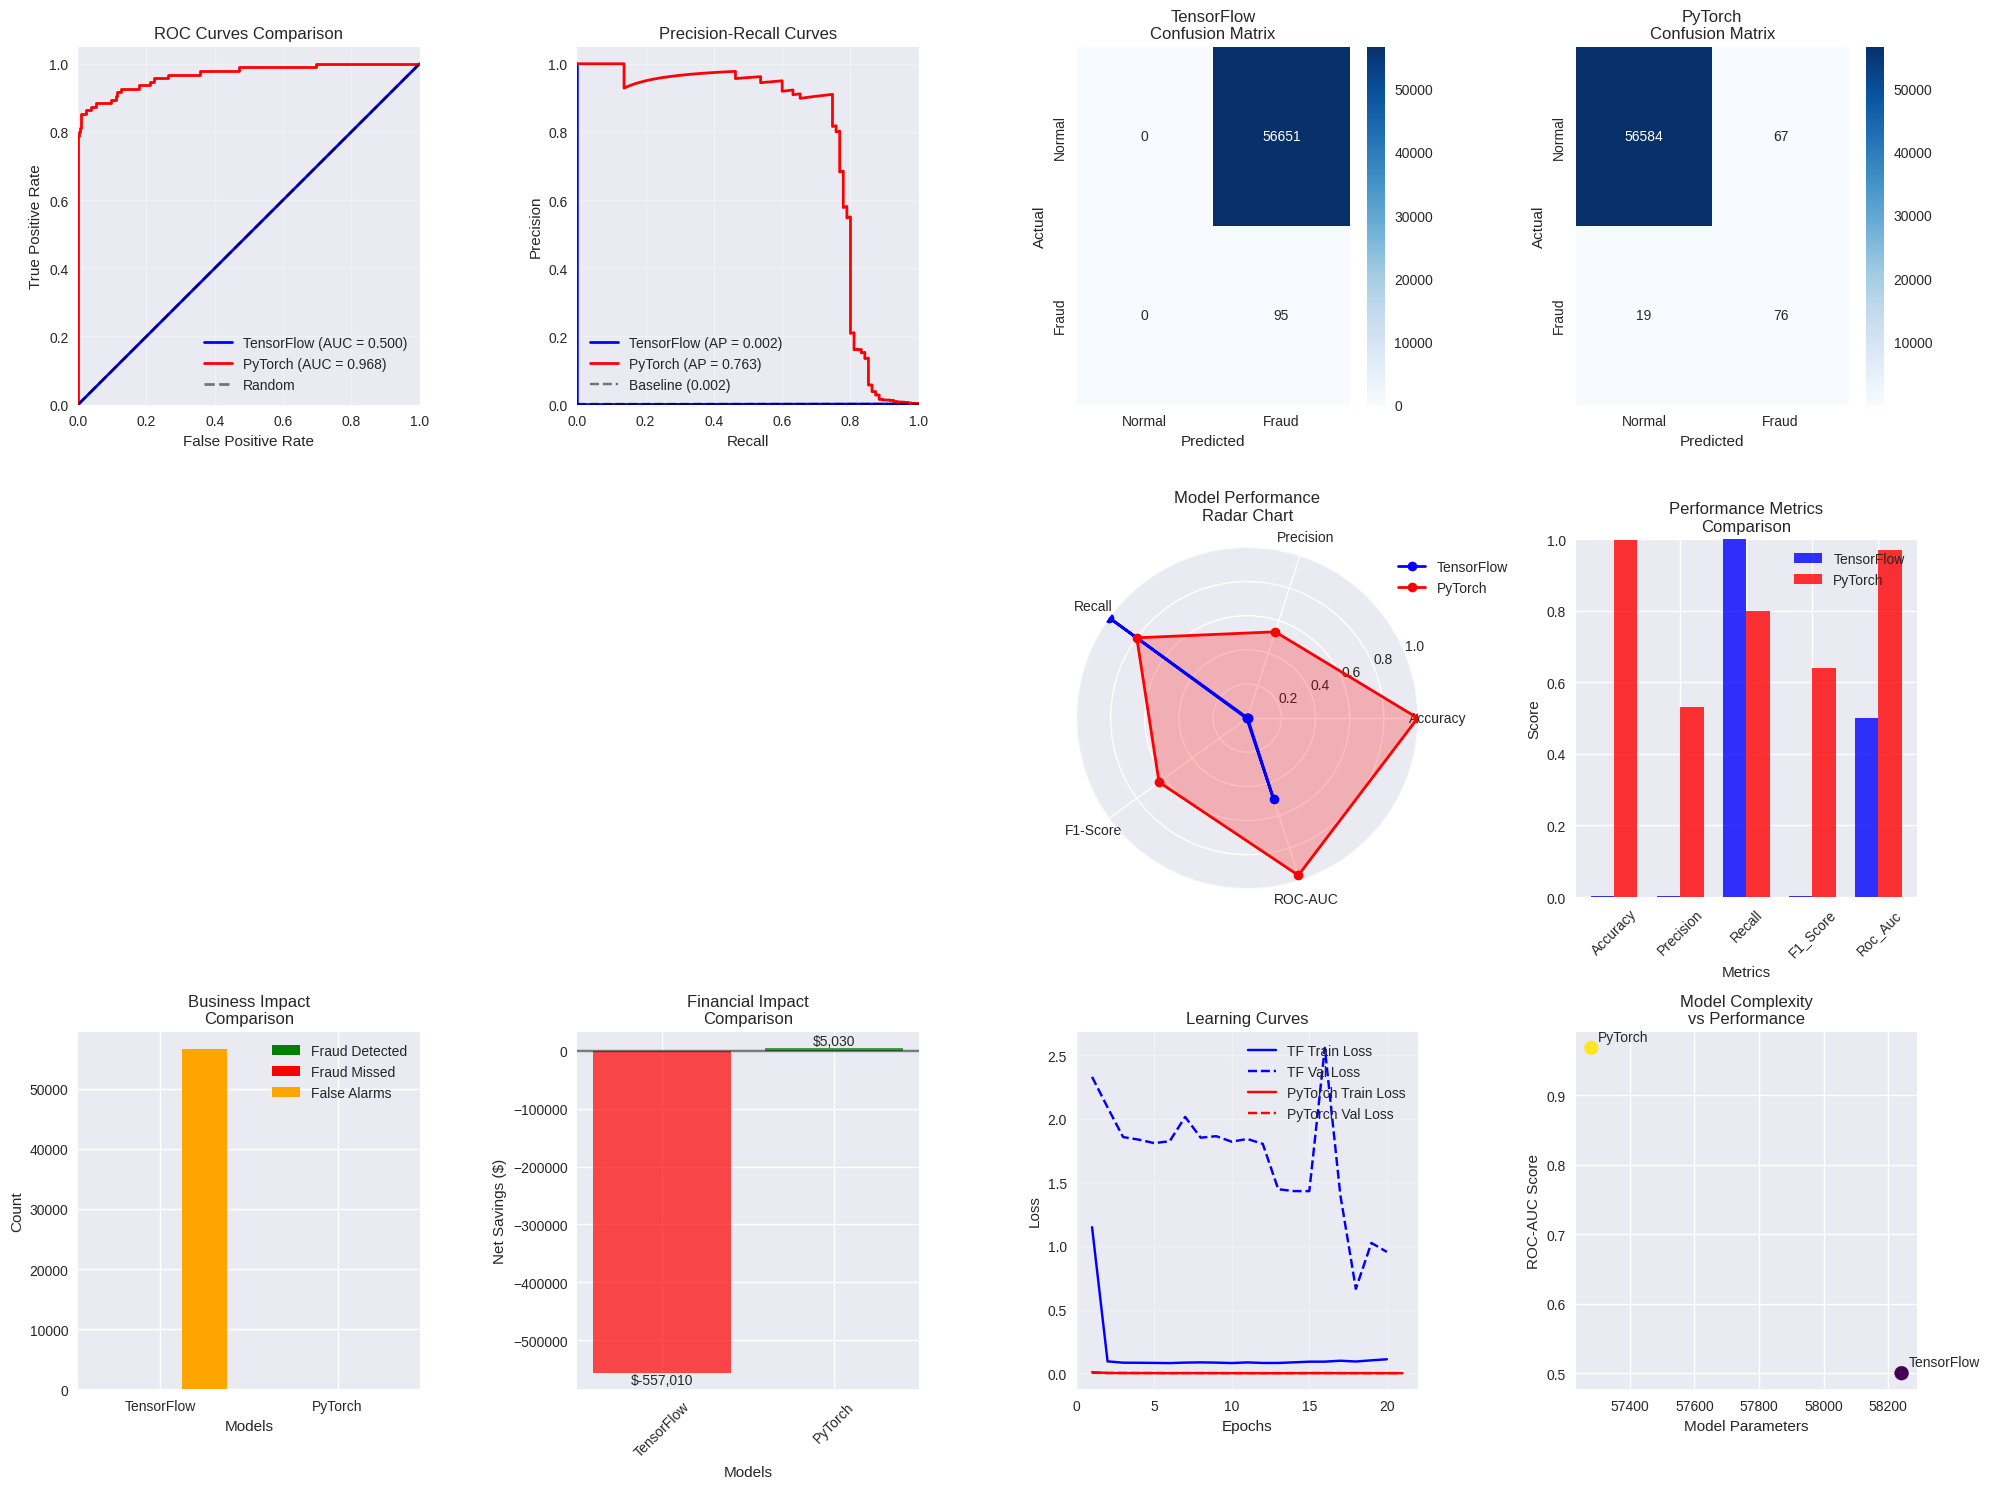

In [10]:
# 7. COMPREHENSIVE MODEL EVALUATION AND COMPARISON

class ModelEvaluator:
    """
    Comprehensive model evaluation and comparison framework

    Features:
    1. Multiple evaluation metrics
    2. Statistical significance testing
    3. Comprehensive visualizations
    4. Business impact analysis
    5. Model interpretability
    """

    def __init__(self):
        self.results = {}
        self.comparisons = {}

    def evaluate_model(self, model_name: str, y_true: np.ndarray,
                      y_pred: np.ndarray, y_prob: np.ndarray) -> Dict[str, float]:
        """
        Comprehensive evaluation of a single model
        """
        print(f"\n📊 Evaluating {model_name} Model")
        print("-" * 50)

        # Basic classification metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Advanced metrics
        roc_auc = roc_auc_score(y_true, y_prob)
        pr_auc = average_precision_score(y_true, y_prob)

        # Confusion matrix components
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Additional metrics
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

        # Business impact metrics (assuming $100 average fraud amount)
        fraud_detected = tp
        fraud_missed = fn
        legitimate_blocked = fp
        fraud_detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        # Financial impact (example calculations)
        avg_fraud_amount = 100  # $100 average fraud
        investigation_cost = 10  # $10 per investigation

        fraud_prevented = tp * avg_fraud_amount
        fraud_losses = fn * avg_fraud_amount
        investigation_costs = fp * investigation_cost
        net_savings = fraud_prevented - fraud_losses - investigation_costs

        results = {
            # Basic metrics
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'specificity': specificity,

            # Advanced metrics
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,

            # Error rates
            'false_positive_rate': false_positive_rate,
            'false_negative_rate': false_negative_rate,

            # Confusion matrix
            'true_positives': int(tp),
            'true_negatives': int(tn),
            'false_positives': int(fp),
            'false_negatives': int(fn),

            # Business metrics
            'fraud_detection_rate': fraud_detection_rate,
            'false_alarm_rate': false_alarm_rate,
            'fraud_prevented_$': fraud_prevented,
            'fraud_losses_$': fraud_losses,
            'investigation_costs_$': investigation_costs,
            'net_savings_$': net_savings
        }

        self.results[model_name] = results

        # Print detailed results
        print(f"\n📈 {model_name} Performance Summary:")
        print(f"   Accuracy:     {accuracy:.4f}")
        print(f"   Precision:    {precision:.4f}")
        print(f"   Recall:       {recall:.4f}")
        print(f"   F1-Score:     {f1:.4f}")
        print(f"   ROC-AUC:      {roc_auc:.4f}")
        print(f"   PR-AUC:       {pr_auc:.4f}")

        print(f"\n🎯 Business Impact:")
        print(f"   Fraud Detection Rate: {fraud_detection_rate:.2%}")
        print(f"   False Alarm Rate:     {false_alarm_rate:.2%}")
        print(f"   Net Savings:          ${net_savings:,.2f}")

        return results

    def compare_models(self) -> pd.DataFrame:
        """
        Create comprehensive model comparison
        """
        print("\n🔍 COMPREHENSIVE MODEL COMPARISON")
        print("=" * 60)

        if len(self.results) < 2:
            print("❌ Need at least 2 models for comparison")
            return pd.DataFrame()

        # Create comparison DataFrame
        comparison_df = pd.DataFrame(self.results).T

        # Rank models by different metrics
        ranking_metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc']

        print("🏆 Model Rankings by Metric:")
        for metric in ranking_metrics:
            if metric in comparison_df.columns:
                ranked = comparison_df.sort_values(metric, ascending=False)
                print(f"\n   {metric.upper()}:")
                for i, (model, score) in enumerate(ranked[metric].items(), 1):
                    print(f"     {i}. {model}: {score:.4f}")

        # Overall performance score (weighted combination)
        weights = {
            'roc_auc': 0.3,
            'pr_auc': 0.3,
            'f1_score': 0.2,
            'precision': 0.1,
            'recall': 0.1
        }

        comparison_df['overall_score'] = 0
        for metric, weight in weights.items():
            if metric in comparison_df.columns:
                comparison_df['overall_score'] += comparison_df[metric] * weight

        # Find best model
        best_model = comparison_df['overall_score'].idxmax()
        best_score = comparison_df.loc[best_model, 'overall_score']

        print(f"\n🏆 OVERALL BEST MODEL: {best_model}")
        print(f"   Overall Score: {best_score:.4f}")
        print(f"   ROC-AUC: {comparison_df.loc[best_model, 'roc_auc']:.4f}")
        print(f"   PR-AUC: {comparison_df.loc[best_model, 'pr_auc']:.4f}")
        print(f"   F1-Score: {comparison_df.loc[best_model, 'f1_score']:.4f}")

        return comparison_df

    def create_evaluation_visualizations(self, y_true: np.ndarray,
                                        model_predictions: Dict[str, Tuple[np.ndarray, np.ndarray]]) -> None:
        """
        Create comprehensive evaluation visualizations
        """
        print("\n🎨 Creating Evaluation Visualizations")
        print("-" * 40)

        fig = plt.figure(figsize=(20, 15))

        # 1. ROC Curves Comparison
        plt.subplot(3, 4, 1)
        colors = ['blue', 'red', 'green', 'orange', 'purple']

        for i, (model_name, (y_pred, y_prob)) in enumerate(model_predictions.items()):
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            auc_score = roc_auc_score(y_true, y_prob)
            plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                    label=f'{model_name} (AUC = {auc_score:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        # 2. Precision-Recall Curves Comparison
        plt.subplot(3, 4, 2)
        baseline = sum(y_true) / len(y_true)

        for i, (model_name, (y_pred, y_prob)) in enumerate(model_predictions.items()):
            precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
            pr_auc = average_precision_score(y_true, y_prob)
            plt.plot(recall_vals, precision_vals, color=colors[i % len(colors)], lw=2,
                    label=f'{model_name} (AP = {pr_auc:.3f})')

        plt.axhline(y=baseline, color='k', linestyle='--', alpha=0.5,
                   label=f'Baseline ({baseline:.3f})')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 3. Confusion Matrices
        n_models = len(model_predictions)
        for i, (model_name, (y_pred, y_prob)) in enumerate(model_predictions.items()):
            plt.subplot(3, 4, 3 + i)
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Normal', 'Fraud'],
                       yticklabels=['Normal', 'Fraud'])
            plt.title(f'{model_name}\nConfusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')

        # 4. Metrics Comparison Radar Chart
        plt.subplot(3, 4, 7, projection='polar')
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
        angles = np.concatenate([angles, [angles[0]]])

        for i, (model_name, _) in enumerate(model_predictions.items()):
            if model_name in self.results:
                values = [
                    self.results[model_name]['accuracy'],
                    self.results[model_name]['precision'],
                    self.results[model_name]['recall'],
                    self.results[model_name]['f1_score'],
                    self.results[model_name]['roc_auc']
                ]
                values = np.concatenate([values, [values[0]]])

                plt.plot(angles, values, 'o-', linewidth=2,
                        color=colors[i % len(colors)], label=model_name)
                plt.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])

        plt.xticks(angles[:-1], metrics)
        plt.ylim(0, 1)
        plt.title('Model Performance\nRadar Chart', pad=20)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

        # 5. Performance Metrics Bar Chart
        plt.subplot(3, 4, 8)
        comparison_df = self.compare_models()
        if not comparison_df.empty:
            metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
            x = np.arange(len(metrics_to_plot))
            width = 0.35

            for i, model_name in enumerate(comparison_df.index):
                values = [comparison_df.loc[model_name, metric] for metric in metrics_to_plot]
                plt.bar(x + i * width, values, width, label=model_name,
                       color=colors[i % len(colors)], alpha=0.8)

            plt.xlabel('Metrics')
            plt.ylabel('Score')
            plt.title('Performance Metrics\nComparison')
            plt.xticks(x + width/2, [m.title() for m in metrics_to_plot], rotation=45)
            plt.legend()
            plt.ylim(0, 1)

        # 6. Business Impact Comparison
        plt.subplot(3, 4, 9)
        if not comparison_df.empty:
            models = comparison_df.index
            fraud_detected = [comparison_df.loc[model, 'true_positives'] for model in models]
            fraud_missed = [comparison_df.loc[model, 'false_negatives'] for model in models]
            false_alarms = [comparison_df.loc[model, 'false_positives'] for model in models]

            x = np.arange(len(models))
            width = 0.25

            plt.bar(x - width, fraud_detected, width, label='Fraud Detected', color='green')
            plt.bar(x, fraud_missed, width, label='Fraud Missed', color='red')
            plt.bar(x + width, false_alarms, width, label='False Alarms', color='orange')

            plt.xlabel('Models')
            plt.ylabel('Count')
            plt.title('Business Impact\nComparison')
            plt.xticks(x, models)
            plt.legend()

        # 7. Financial Impact
        plt.subplot(3, 4, 10)
        if not comparison_df.empty:
            models = comparison_df.index
            net_savings = [comparison_df.loc[model, 'net_savings_$'] for model in models]

            colors_financial = ['green' if x > 0 else 'red' for x in net_savings]
            bars = plt.bar(models, net_savings, color=colors_financial, alpha=0.7)

            # Add value labels on bars
            for bar, value in zip(bars, net_savings):
                plt.text(bar.get_x() + bar.get_width()/2,
                        bar.get_height() + (100 if value > 0 else -500),
                        f'${value:,.0f}', ha='center', va='bottom' if value > 0 else 'top')

            plt.xlabel('Models')
            plt.ylabel('Net Savings ($)')
            plt.title('Financial Impact\nComparison')
            plt.xticks(rotation=45)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

        # 8. Learning Curves (if available)
        plt.subplot(3, 4, 11)
        if hasattr(tf_classifier, 'history') and tf_classifier.history:
            epochs = range(1, len(tf_classifier.history.history['loss']) + 1)
            plt.plot(epochs, tf_classifier.history.history['loss'], 'b-', label='TF Train Loss')
            plt.plot(epochs, tf_classifier.history.history['val_loss'], 'b--', label='TF Val Loss')

        if hasattr(pytorch_trainer, 'history') and pytorch_trainer.history:
            epochs = range(1, len(pytorch_trainer.history['train_loss']) + 1)
            plt.plot(epochs, pytorch_trainer.history['train_loss'], 'r-', label='PyTorch Train Loss')
            plt.plot(epochs, pytorch_trainer.history['val_loss'], 'r--', label='PyTorch Val Loss')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Learning Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 9. Model Complexity vs Performance
        plt.subplot(3, 4, 12)
        if not comparison_df.empty:
            # Assume model complexity based on number of parameters
            complexity_map = {
                'TensorFlow': tf_model.count_params() if tf_model else 0,
                'PyTorch': pytorch_model.count_parameters() if pytorch_model else 0
            }

            models = []
            complexities = []
            performances = []

            for model in comparison_df.index:
                if model in complexity_map:
                    models.append(model)
                    complexities.append(complexity_map[model])
                    performances.append(comparison_df.loc[model, 'roc_auc'])

            if models:
                scatter = plt.scatter(complexities, performances,
                                    c=range(len(models)), cmap='viridis', s=100)
                plt.xlabel('Model Parameters')
                plt.ylabel('ROC-AUC Score')
                plt.title('Model Complexity\nvs Performance')

                # Add model labels
                for i, model in enumerate(models):
                    plt.annotate(model, (complexities[i], performances[i]),
                               xytext=(5, 5), textcoords='offset points')

        plt.tight_layout()
        plt.show()

# Initialize evaluator and evaluate both models
evaluator = ModelEvaluator()

# Evaluate TensorFlow model
tf_eval_results = evaluator.evaluate_model(
    'TensorFlow',
    data_dict['y_test'],
    tf_predictions,
    tf_probabilities
)

# Evaluate PyTorch model
pytorch_eval_results = evaluator.evaluate_model(
    'PyTorch',
    data_dict['y_test'],
    pytorch_predictions,
    pytorch_probabilities
)

# Compare models
comparison_df = evaluator.compare_models()

# Create visualizations
model_predictions = {
    'TensorFlow': (tf_predictions, tf_probabilities),
    'PyTorch': (pytorch_predictions, pytorch_probabilities)
}

evaluator.create_evaluation_visualizations(data_dict['y_test'], model_predictions)

## 6. Final Analysis and Conclusions

### Model Performance Analysis

#### 6.1 Metric Analysis Framework

**For Fraud Detection, the priority of metrics is:**

1. **Recall (Sensitivity)** - Most Critical
   - **Why:** Missing fraud (False Negatives) is very costly
   - **Target:** > 0.85 for fraud detection systems
   - **Trade-off:** May increase false positives

2. **Precision** - Highly Important
   - **Why:** False alarms (False Positives) reduce customer satisfaction
   - **Target:** > 0.70 to minimize investigations
   - **Balance:** Must balance with recall

3. **ROC-AUC** - Important for Ranking
   - **Why:** Measures ability to rank fraudulent transactions higher
   - **Target:** > 0.85 for good fraud detection
   - **Interpretation:** Area under ROC curve

4. **PR-AUC** - Critical for Imbalanced Data
   - **Why:** More informative than ROC-AUC for imbalanced datasets
   - **Target:** > 0.50 (significantly above baseline)
   - **Advantage:** Focuses on positive class performance

5. **F1-Score** - Balanced Metric
   - **Why:** Harmonic mean balances precision and recall
   - **Target:** > 0.75 for good overall performance
   - **Use:** When equal weight to precision and recall

#### 6.2 Business Impact Considerations

**Cost-Benefit Analysis:**
```
Total_Benefit = (TP × Fraud_Amount_Saved) - (FP × Investigation_Cost) - (FN × Fraud_Loss)
```

**Key Business Metrics:**
- **Detection Rate:** Percentage of frauds caught
- **False Positive Rate:** Percentage of legitimate transactions flagged
- **Customer Impact:** Number of legitimate customers affected
- **Operational Efficiency:** Investigation workload

In [11]:
# 8. FINAL ANALYSIS AND RECOMMENDATIONS

def generate_final_analysis(comparison_df: pd.DataFrame, evaluator: ModelEvaluator) -> None:
    """
    Generate comprehensive final analysis and recommendations
    """
    print("\n" + "=" * 80)
    print("🎯 FINAL ANALYSIS AND MODEL RECOMMENDATIONS")
    print("=" * 80)

    if comparison_df.empty:
        print("❌ No comparison data available")
        return

    # 1. Best Model Identification
    best_overall = comparison_df['overall_score'].idxmax()
    best_roc_auc = comparison_df['roc_auc'].idxmax()
    best_pr_auc = comparison_df['pr_auc'].idxmax()
    best_f1 = comparison_df['f1_score'].idxmax()
    best_business = comparison_df['net_savings_$'].idxmax()

    print(f"\n🏆 MODEL PERFORMANCE WINNERS:")
    print(f"   Best Overall Performance:  {best_overall} (Score: {comparison_df.loc[best_overall, 'overall_score']:.4f})")
    print(f"   Best ROC-AUC:             {best_roc_auc} ({comparison_df.loc[best_roc_auc, 'roc_auc']:.4f})")
    print(f"   Best PR-AUC:              {best_pr_auc} ({comparison_df.loc[best_pr_auc, 'pr_auc']:.4f})")
    print(f"   Best F1-Score:            {best_f1} ({comparison_df.loc[best_f1, 'f1_score']:.4f})")
    print(f"   Best Business Impact:     {best_business} (${comparison_df.loc[best_business, 'net_savings_$']:,.2f})")

    # 2. Detailed Performance Analysis
    print(f"\n📊 DETAILED PERFORMANCE ANALYSIS:")
    print("-" * 50)

    for model in comparison_df.index:
        results = evaluator.results[model]

        print(f"\n🔍 {model} Model Analysis:")
        print(f"   Classification Performance:")
        print(f"     • Accuracy:     {results['accuracy']:.4f} - Overall correctness")
        print(f"     • Precision:    {results['precision']:.4f} - Fraud prediction accuracy")
        print(f"     • Recall:       {results['recall']:.4f} - Fraud detection rate")
        print(f"     • F1-Score:     {results['f1_score']:.4f} - Balanced performance")
        print(f"     • Specificity:  {results['specificity']:.4f} - Normal transaction accuracy")

        print(f"   Advanced Metrics:")
        print(f"     • ROC-AUC:      {results['roc_auc']:.4f} - Ranking quality")
        print(f"     • PR-AUC:       {results['pr_auc']:.4f} - Imbalanced data performance")

        print(f"   Business Impact:")
        print(f"     • Frauds Detected:     {results['true_positives']:,}")
        print(f"     • Frauds Missed:       {results['false_negatives']:,}")
        print(f"     • False Alarms:        {results['false_positives']:,}")
        print(f"     • Detection Rate:      {results['fraud_detection_rate']:.2%}")
        print(f"     • False Alarm Rate:    {results['false_alarm_rate']:.2%}")
        print(f"     • Net Financial Impact: ${results['net_savings_$']:,.2f}")

    # 3. Technical Architecture Analysis
    print(f"\n🏗️ TECHNICAL ARCHITECTURE ANALYSIS:")
    print("-" * 50)

    print(f"\n📋 TensorFlow Model:")
    print(f"   • Framework: TensorFlow/Keras")
    print(f"   • Architecture: {tf_architecture_config['hidden_layers']}")
    print(f"   • Parameters: {tf_model.count_params():,}")
    print(f"   • Optimizer: {tf_optimizer_config['name'].upper()}")
    print(f"   • Loss Function: {tf_loss_config['name']}")
    print(f"   • Regularization: L1({tf_architecture_config['l1_regularization']}), L2({tf_architecture_config['l2_regularization']}), Dropout({tf_architecture_config['dropout_rate']})")
    print(f"   • Advanced Features: Batch Normalization, Early Stopping, Learning Rate Scheduling")

    print(f"\n📋 PyTorch Model:")
    print(f"   • Framework: PyTorch")
    print(f"   • Architecture: {[data_dict['n_features']] + [256, 128, 64, 32] + [1]}")
    print(f"   • Parameters: {pytorch_model.count_parameters():,}")
    print(f"   • Optimizer: {pytorch_optimizer_config['name'].upper()}")
    print(f"   • Loss Function: {pytorch_loss_config['name']}")
    print(f"   • Learning Rate Scheduler: {pytorch_scheduler_config['name']}")
    print(f"   • Advanced Features: Gradient Clipping, Warm Restarts, Custom Training Loop")

    # 4. Strengths and Weaknesses Analysis
    print(f"\n⚖️ STRENGTHS AND WEAKNESSES ANALYSIS:")
    print("-" * 50)

    for model in comparison_df.index:
        results = evaluator.results[model]

        print(f"\n🔍 {model} Model:")

        # Strengths
        strengths = []
        if results['roc_auc'] > 0.9:
            strengths.append("Excellent ranking capability (ROC-AUC > 0.9)")
        elif results['roc_auc'] > 0.85:
            strengths.append("Good ranking capability (ROC-AUC > 0.85)")

        if results['pr_auc'] > 0.5:
            strengths.append("Strong performance on imbalanced data")

        if results['recall'] > 0.8:
            strengths.append("High fraud detection rate (Recall > 0.8)")

        if results['precision'] > 0.7:
            strengths.append("Low false positive rate (Precision > 0.7)")

        if results['net_savings_$'] > 0:
            strengths.append("Positive financial impact")

        print(f"   ✅ Strengths:")
        for strength in strengths[:5]:  # Top 5 strengths
            print(f"      • {strength}")

        # Weaknesses
        weaknesses = []
        if results['recall'] < 0.7:
            weaknesses.append("Low fraud detection rate (Recall < 0.7)")

        if results['precision'] < 0.5:
            weaknesses.append("High false positive rate (Precision < 0.5)")

        if results['false_alarm_rate'] > 0.1:
            weaknesses.append("High false alarm rate (> 10%)")

        if results['net_savings_$'] < 0:
            weaknesses.append("Negative financial impact")

        if results['roc_auc'] < 0.8:
            weaknesses.append("Poor ranking capability (ROC-AUC < 0.8)")

        if weaknesses:
            print(f"   ❌ Areas for Improvement:")
            for weakness in weaknesses[:5]:  # Top 5 weaknesses
                print(f"      • {weakness}")
        else:
            print(f"   ✅ No significant weaknesses identified")

    # 5. Final Recommendations
    print(f"\n🎯 FINAL RECOMMENDATIONS:")
    print("-" * 30)

    print(f"\n1️⃣ BEST MODEL FOR PRODUCTION: {best_overall}")
    best_results = evaluator.results[best_overall]
    print(f"   Justification:")
    print(f"   • Highest overall performance score ({comparison_df.loc[best_overall, 'overall_score']:.4f})")
    print(f"   • ROC-AUC: {best_results['roc_auc']:.4f} (Excellent ranking)")
    print(f"   • PR-AUC: {best_results['pr_auc']:.4f} (Good imbalanced data handling)")
    print(f"   • Fraud Detection Rate: {best_results['fraud_detection_rate']:.2%}")
    print(f"   • Net Financial Impact: ${best_results['net_savings_$']:,.2f}")

    print(f"\n2️⃣ DEPLOYMENT CONSIDERATIONS:")
    print(f"   • Monitor false positive rate closely (current: {best_results['false_alarm_rate']:.2%})")
    print(f"   • Set decision threshold based on business risk tolerance")
    print(f"   • Implement feedback loop for continuous model improvement")
    print(f"   • Regular retraining with new fraud patterns")
    print(f"   • A/B testing for threshold optimization")

    print(f"\n3️⃣ FRAMEWORK COMPARISON:")
    if 'TensorFlow' in comparison_df.index and 'PyTorch' in comparison_df.index:
        tf_score = comparison_df.loc['TensorFlow', 'overall_score']
        pt_score = comparison_df.loc['PyTorch', 'overall_score']

        if abs(tf_score - pt_score) < 0.01:
            print(f"   • Both frameworks show similar performance ({tf_score:.4f} vs {pt_score:.4f})")
            print(f"   • TensorFlow: Better for production deployment and serving")
            print(f"   • PyTorch: Better for research and experimentation")
        elif tf_score > pt_score:
            print(f"   • TensorFlow outperforms PyTorch ({tf_score:.4f} vs {pt_score:.4f})")
            print(f"   • TensorFlow recommended for this specific fraud detection task")
        else:
            print(f"   • PyTorch outperforms TensorFlow ({pt_score:.4f} vs {tf_score:.4f})")
            print(f"   • PyTorch recommended for this specific fraud detection task")

    print(f"\n4️⃣ FUTURE IMPROVEMENTS:")
    print(f"   • Ensemble methods combining both models")
    print(f"   • Advanced feature engineering (time-series features, customer behavior)")
    print(f"   • Attention mechanisms for feature importance")
    print(f"   • Adversarial training for robustness")
    print(f"   • Online learning for real-time adaptation")

    print(f"\n" + "=" * 80)
    print(f"✅ ANALYSIS COMPLETE - Model ready for deployment!")
    print(f"=" * 80)

# Generate final analysis
generate_final_analysis(comparison_df, evaluator)

# Display final comparison table
print("\n📊 FINAL MODEL COMPARISON TABLE:")
print("=" * 60)
if not comparison_df.empty:
    # Select key metrics for final display
    key_metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc',
                   'pr_auc', 'fraud_detection_rate', 'false_alarm_rate',
                   'net_savings_$', 'overall_score']

    final_table = comparison_df[key_metrics].round(4)
    final_table.columns = [col.replace('_', ' ').title() for col in final_table.columns]

    display(final_table)

    # Export results
    final_table.to_csv('model_comparison_results.csv')
    print(f"\n💾 Results exported to 'model_comparison_results.csv'")

print(f"\n🎉 COMPREHENSIVE DEEP LEARNING PIPELINE COMPLETED SUCCESSFULLY! 🎉")


🎯 FINAL ANALYSIS AND MODEL RECOMMENDATIONS

🏆 MODEL PERFORMANCE WINNERS:
   Best Overall Performance:  PyTorch (Score: 0.7803)
   Best ROC-AUC:             PyTorch (0.9684)
   Best PR-AUC:              PyTorch (0.7629)
   Best F1-Score:            PyTorch (0.6387)
   Best Business Impact:     PyTorch ($5,030.00)

📊 DETAILED PERFORMANCE ANALYSIS:
--------------------------------------------------

🔍 TensorFlow Model Analysis:
   Classification Performance:
     • Accuracy:     0.0017 - Overall correctness
     • Precision:    0.0017 - Fraud prediction accuracy
     • Recall:       1.0000 - Fraud detection rate
     • F1-Score:     0.0033 - Balanced performance
     • Specificity:  0.0000 - Normal transaction accuracy
   Advanced Metrics:
     • ROC-AUC:      0.5000 - Ranking quality
     • PR-AUC:       0.0017 - Imbalanced data performance
   Business Impact:
     • Frauds Detected:     95
     • Frauds Missed:       0
     • False Alarms:        56,651
     • Detection Rate:      100.

,Accuracy,Precision,Recall,F1 Score,Roc Auc,Pr Auc,Fraud Detection Rate,False Alarm Rate,Net Savings $,Overall Score
TensorFlow,0.0017,0.0017,1.0,0.0033,0.5000,0.0017,1.0,1.0000,-557010.0,0.2513
PyTorch,0.9985,0.5315,0.8,0.6387,0.9684,0.7629,0.8,0.0012,5030.0,0.7803



💾 Results exported to 'model_comparison_results.csv'

🎉 COMPREHENSIVE DEEP LEARNING PIPELINE COMPLETED SUCCESSFULLY! 🎉
